In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# 1. Carga DE dataset
data = pd.read_csv("sport_car_price.csv")

data['Engine Size (L)'] = pd.to_numeric(data['Engine Size (L)'], errors='coerce')
data['Horsepower'] = pd.to_numeric(data['Horsepower'].str.replace(',', ''), errors='coerce')
data['Torque (lb-ft)'] = pd.to_numeric(data['Torque (lb-ft)'].str.replace(',', ''), errors='coerce')
data['0-60 MPH Time (seconds)'] = pd.to_numeric(data['0-60 MPH Time (seconds)'], errors='coerce')
data['Price (in USD)'] = pd.to_numeric(data['Price (in USD)'].str.replace(',', ''), errors='coerce')

# 2. Clasificación de variables
categorical_vars = ['Car Make', 'Car Model']
continuous_vars = ['Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)', 'Price (in USD)']


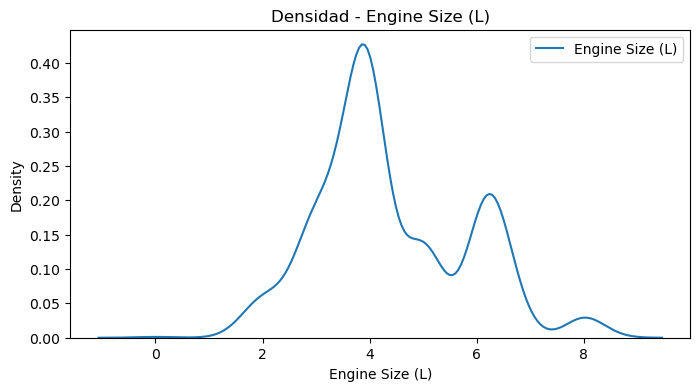

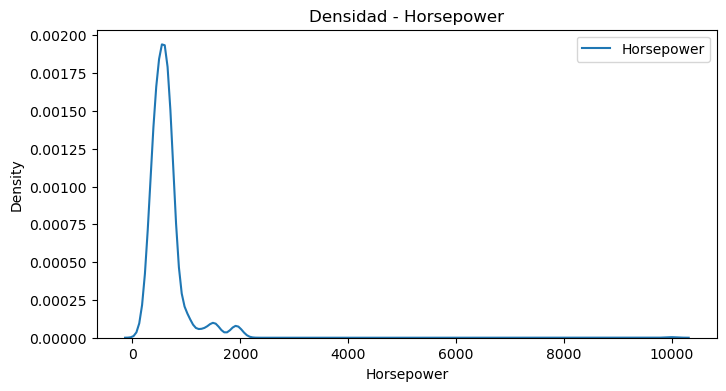

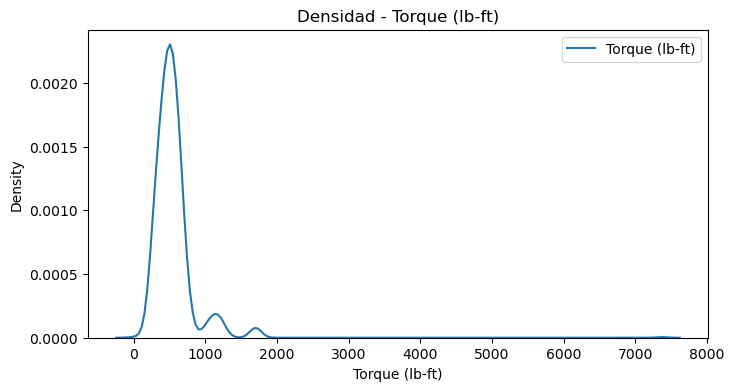

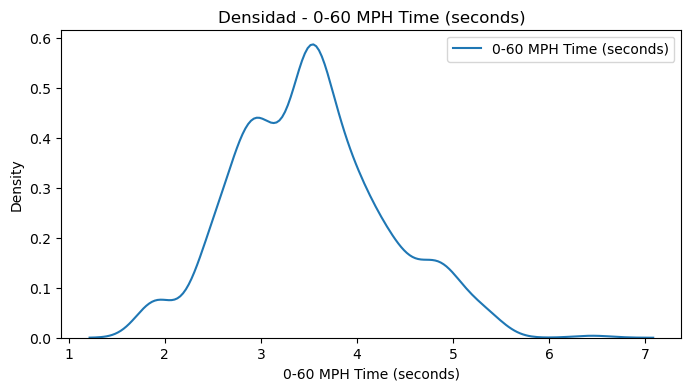

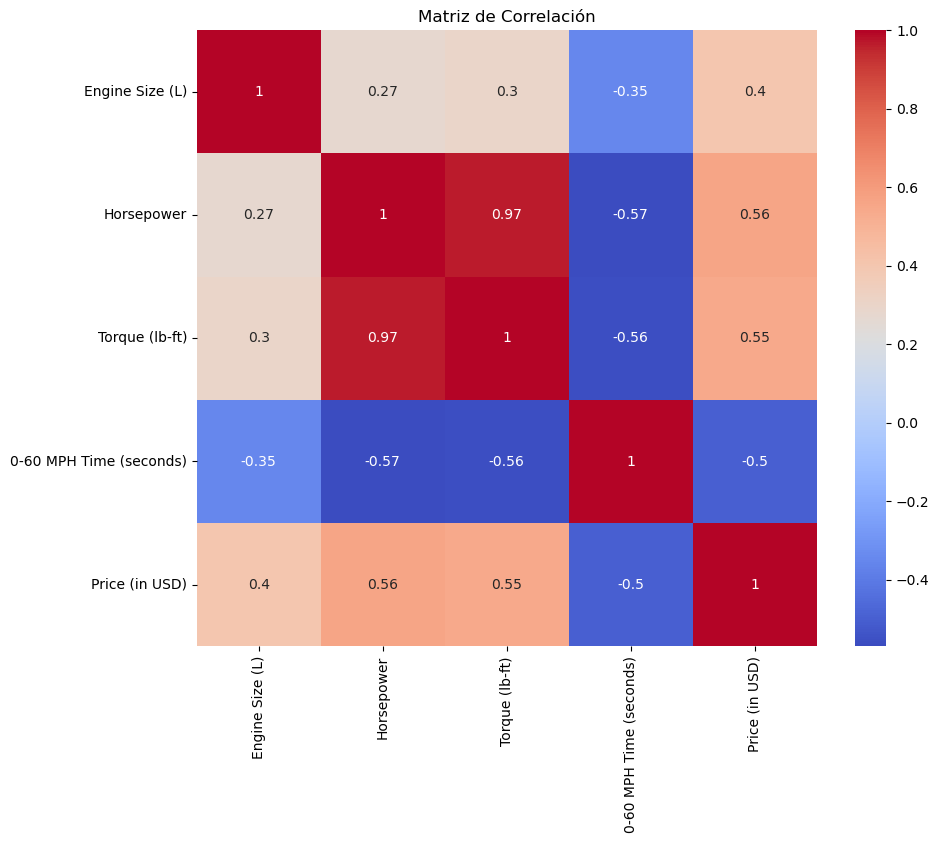

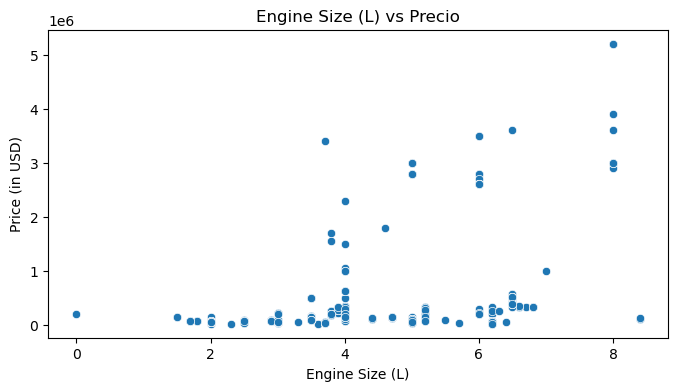

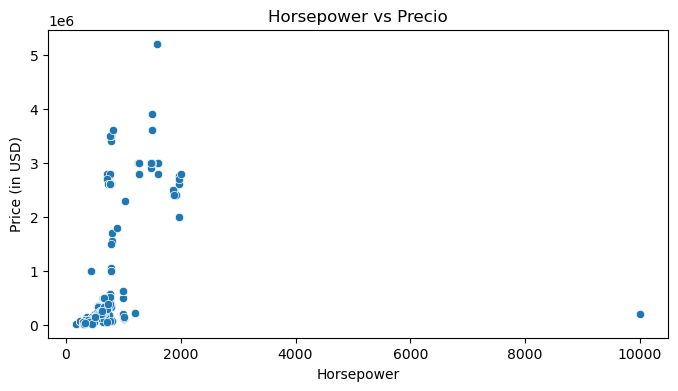

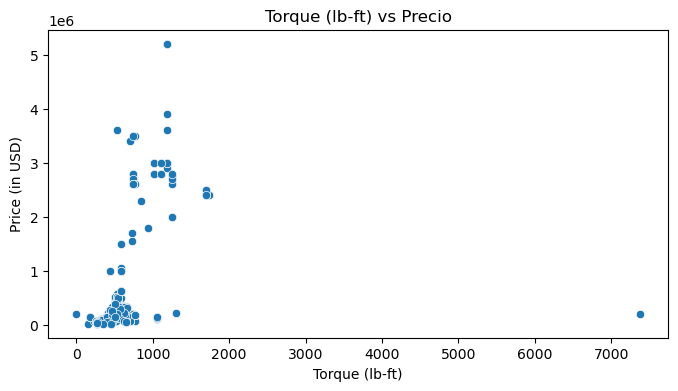

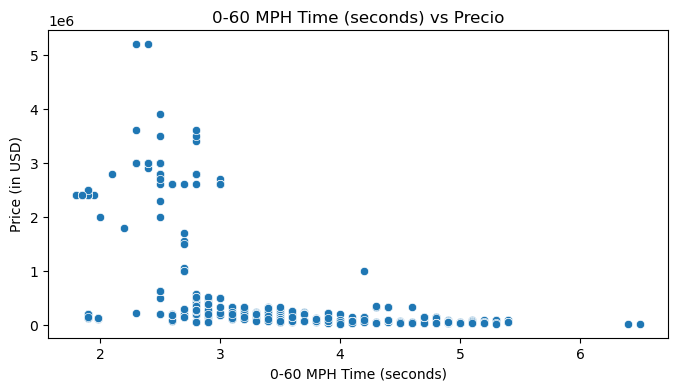

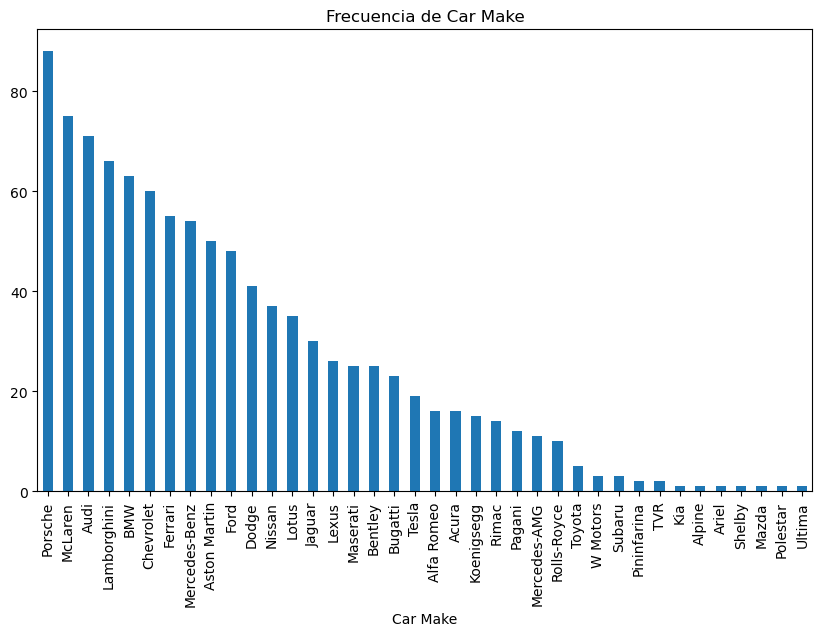

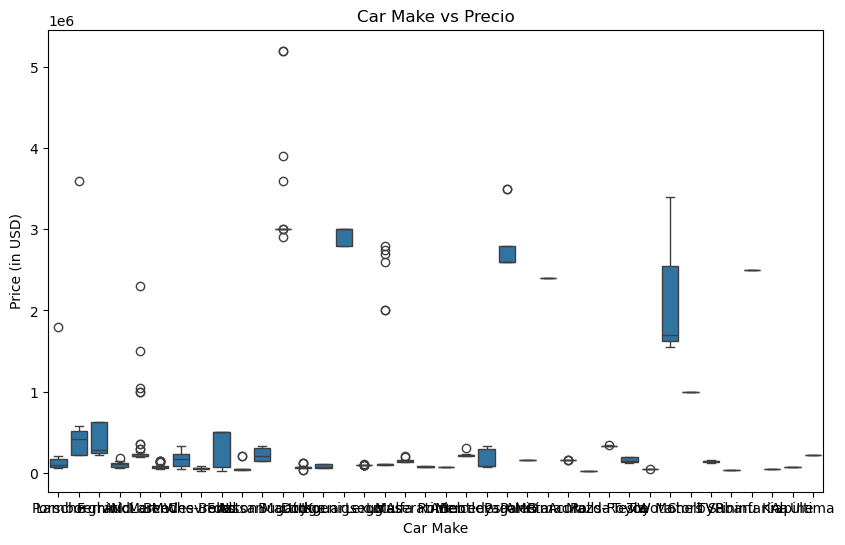

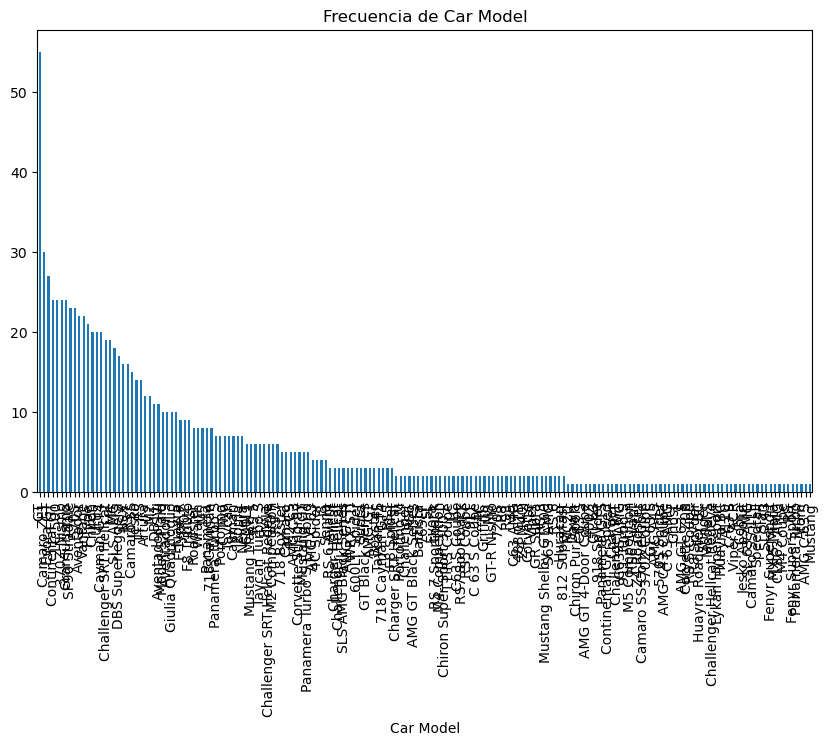

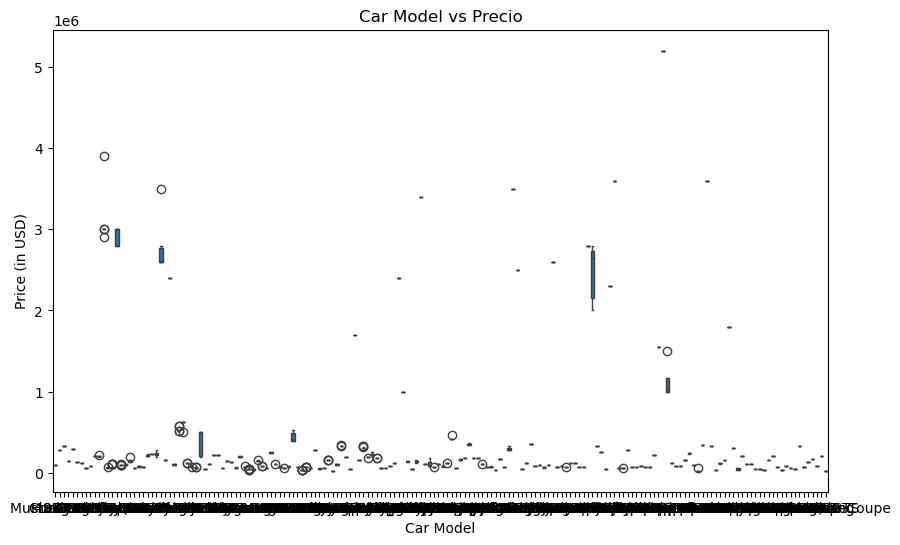

In [8]:
# 3. Análisis descriptivo
# a. Variables numéricas
for var in continuous_vars:
    if var != 'Price (in USD)':  # Saltar el target
        plt.figure(figsize=(8, 4))
        sns.kdeplot(data[var], label=var)
        plt.title(f'Densidad - {var}')
        plt.legend()
        plt.show()

# Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(data[continuous_vars].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Scatter plots con la variable target
for var in continuous_vars:
    if var != 'Price (in USD)':
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=data[var], y=data['Price (in USD)'])
        plt.title(f'{var} vs Precio')
        plt.show()

# b. Variables categóricas
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    data[var].value_counts().plot(kind='bar')
    plt.title(f'Frecuencia de {var}')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[var], y=data['Price (in USD)'])
    plt.title(f'{var} vs Precio')
    plt.show()


In [14]:
# Identificación valores faltantes
print(data.isnull().sum())

# Imputación valores faltantes en las columnas numéricas con la mediana
numeric_cols = ['Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)']
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Verificación
print(data.isnull().sum())

# Separación características y variable objetivo
X = data.drop(['Price (in USD)', 'Car Make', 'Car Model'], axis=1)
y = data['Price (in USD)']

# Divición los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Entrenamiento de los modelos nuevamente
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

rmse_scores = {}
for name, model in models.items():
    scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores[name] = np.mean(scores)

# Tabla de RMSE
import pandas as pd
rmse_df = pd.DataFrame({'Model': rmse_scores.keys(), 'RMSE': rmse_scores.values()})
rmse_df = rmse_df.sort_values(by='RMSE')
print(rmse_df)


Car Make                    0
Car Model                   0
Year                        0
Engine Size (L)            59
Horsepower                  6
Torque (lb-ft)              5
0-60 MPH Time (seconds)     1
Price (in USD)              0
dtype: int64
Car Make                   0
Car Model                  0
Year                       0
Engine Size (L)            0
Horsepower                 0
Torque (lb-ft)             0
0-60 MPH Time (seconds)    0
Price (in USD)             0
dtype: int64
               Model           RMSE
4  Gradient Boosting  189464.366375
3      Random Forest  198251.036098
1              Ridge  786353.109359
2              Lasso  786636.448376
0  Linear Regression  786637.659791


In [16]:
# 7: Reentreno los dos mejores modelos con el 85% de los datos
top_2_models = rmse_df.head(2)['Model'].tolist()
final_models = {name: models[name].fit(X_train, y_train) for name in top_2_models}

#8: Calculo del RMSE en el conjunto de prueba
from sklearn.metrics import mean_squared_error

test_rmse = {}
for name, model in final_models.items():
    y_pred = model.predict(X_test)
    test_rmse[name] = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE en el conjunto de prueba:")
for name, rmse in test_rmse.items():
    print(f"{name}: {rmse}")

RMSE en el conjunto de prueba:
Gradient Boosting: 314657.44089575065
Random Forest: 307693.19188359653


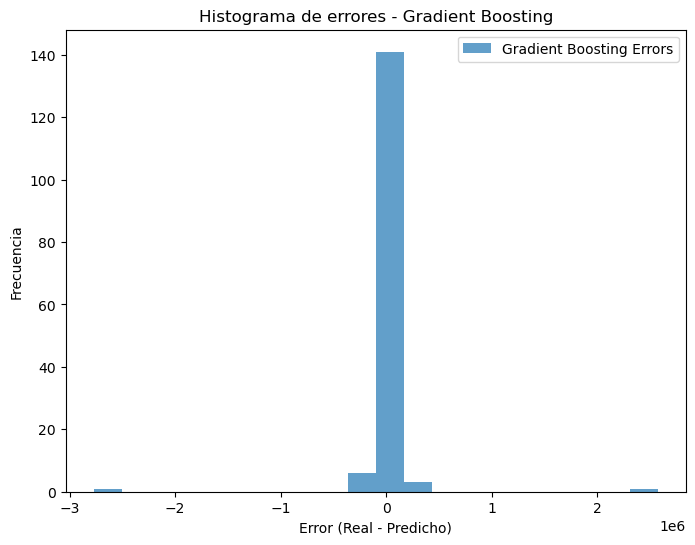

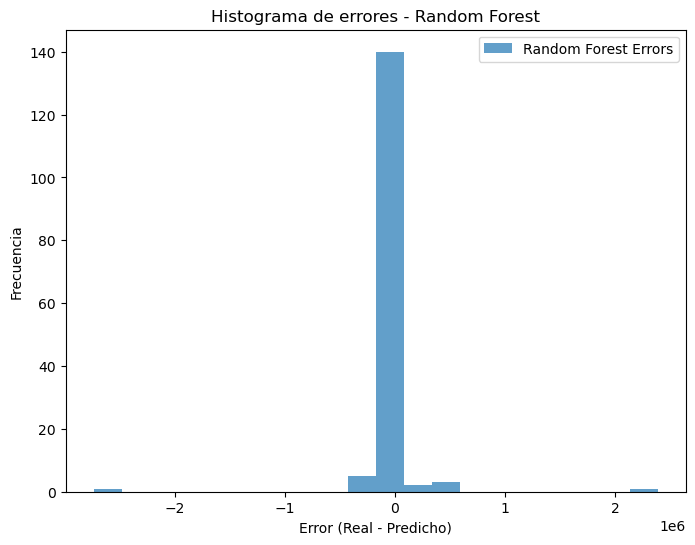

In [18]:
# 9 histograma de predicciones vs valores reales
for name, model in final_models.items():
    y_pred = model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.hist(y_test - y_pred, bins=20, alpha=0.7, label=f'{name} Errors')
    plt.title(f'Histograma de errores - {name}')
    plt.xlabel('Error (Real - Predicho)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()

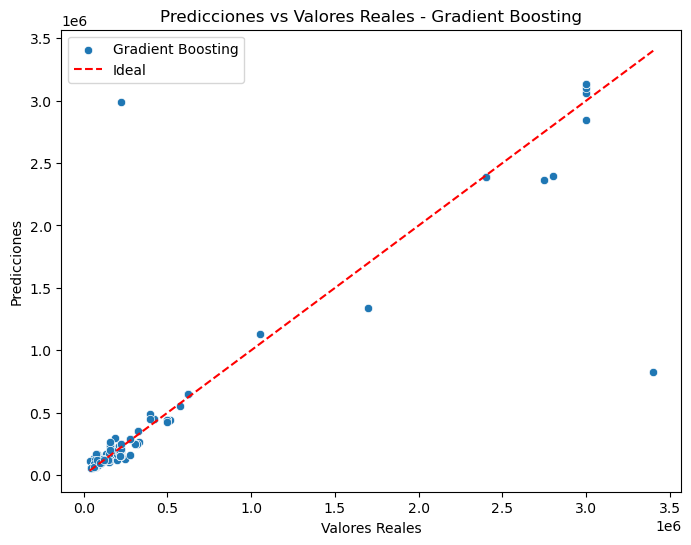

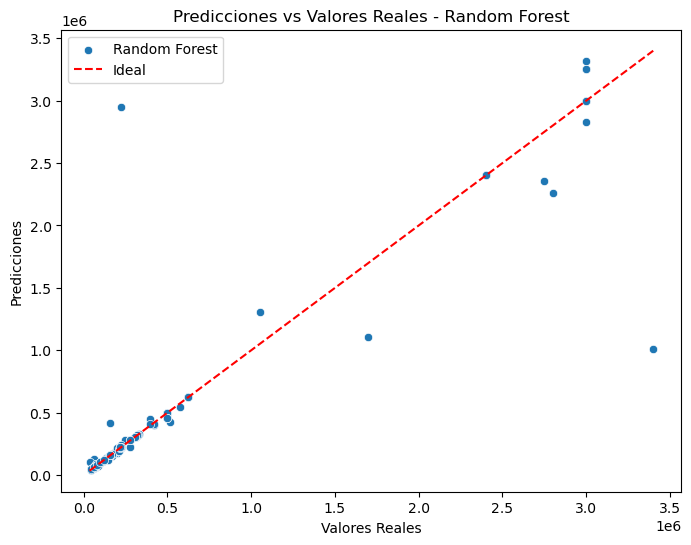

In [20]:
#10 scatter plot de predicciones vs valores reales
for name, model in final_models.items():
    y_pred = model.predict(X_test)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, label=name)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', label='Ideal')
    plt.title(f'Predicciones vs Valores Reales - {name}')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.legend()
    plt.show()

In [22]:
#11: Resultados finales de RMSE
print("\nResultados finales de RMSE (Conjunto de Prueba):")
for name, rmse in test_rmse.items():
    print(f"{name}: {rmse}")

#12 Conclusión final
print("\nConclusión:")
print("Basándonos en los resultados, los modelos más efectivos son los seleccionados.")
print("El modelo más preciso puede ser utilizado para realizar predicciones futuras, dependiendo del RMSE obtenido.")


Resultados finales de RMSE (Conjunto de Prueba):
Gradient Boosting: 314657.44089575065
Random Forest: 307693.19188359653

Conclusión:
Basándonos en los resultados, los modelos más efectivos son los seleccionados.
El modelo más preciso puede ser utilizado para realizar predicciones futuras, dependiendo del RMSE obtenido.
